#ЛР3
##Цель работы:
Научиться создавать простые системы классификации изображений на основе сверточных
нейронных сетей.
##Задание:
1. Выбрать цель для задачи классификации и датасет (train/val: собрать либо найти,
например, на Kaggle, test: собрать, разметить, не менее 50 изображений).
2. Зафиксировать архитектуру сети, loss, метрики качества.
3. Натренировать (либо дотренировать сеть) на выбранном датасете
4. Оценить качество работы по выбранной метрике на валидационной выборке,
определить, не переобучилась ли модель.

In [ ]:
import os
import shutil
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def unzip_file(zip_path, extract_to=None, delete_zip=False):
    '''
    Распаковка ZIP-архива
    '''

    # Если папка для распаковки не указана, создаем рядом
    if extract_to is None:
        extract_to = os.path.splitext(zip_path)[0]

    # Создаем папку, если ее нет
    os.makedirs(extract_to, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Получаем информацию о файлах
            file_list = zip_ref.namelist()
            print(f"Найдено {len(file_list)} файлов в архиве")

            # Распаковываем все файлы
            zip_ref.extractall(extract_to)


    except zipfile.BadZipFile:
        print(f"Ошибка: {zip_path} не является корректным ZIP-архивом")
        return False
    except Exception as e:
        print(f"Ошибка при распаковке: {e}")
        return False

    # Удаляем архив, если нужно
    if delete_zip:
        os.remove(zip_path)
        print(f"Архив удален: {zip_path}")

    return True

In [ ]:
# Распаковка архива
unzip_file('/content/gdrive/MyDrive/CV/dataRGB.zip', 'dataRGB')

Найдено 125499 файлов в архиве


True

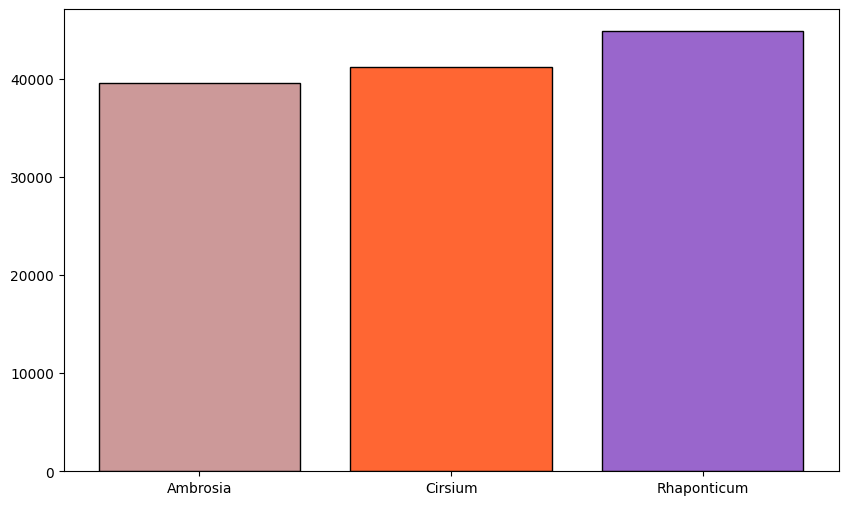

In [ ]:
class_names = ['Ambrosia', 'Cirsium', 'Rhaponticum']

n_ambrosia = len(os.listdir('dataRGB/Ambrosia'))
n_cirsium = len(os.listdir('dataRGB/Cirsium'))
n_rhaponticum = len(os.listdir('dataRGB/Rhaponticum'))

n_images = [n_ambrosia, n_cirsium, n_rhaponticum]

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, n_images, color=['#CC9999', '#FF6633', '#9966CC'], edgecolor='black')

Displaying 3 images from class: Ambrosia
Displaying 3 images from class: Cirsium
Displaying 3 images from class: Rhaponticum


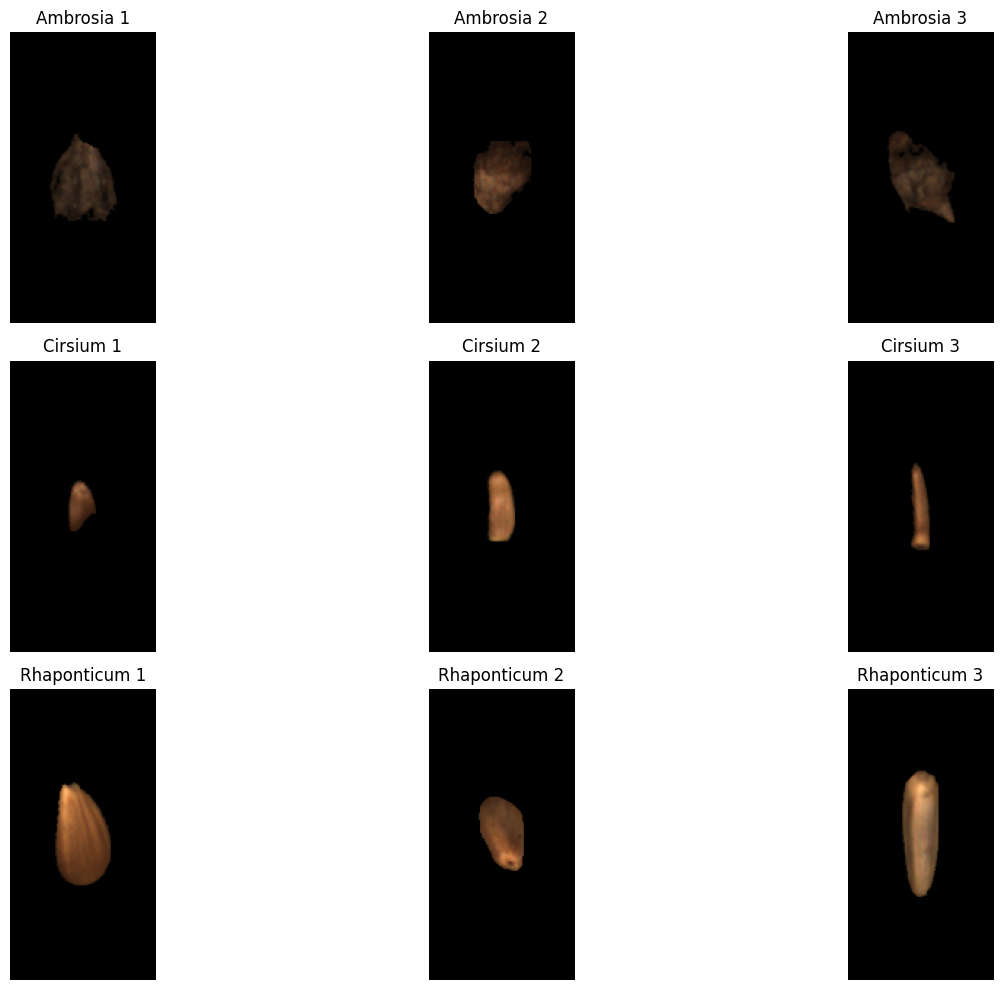

In [ ]:
import matplotlib.pyplot as plt
import random
import os

plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join('dataRGB', class_name)
    images = os.listdir(class_dir)

    # Select 3 random images from the current class
    selected_images = random.sample(images, 3)

    print(f"Displaying 3 images from class: {class_name}")

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(class_dir, img_name)
        img = plt.imread(img_path)

        # Create a subplot for each image
        # (Number of classes * 3 images per class, current image index)
        plt.subplot(len(class_names), 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.title(f"{class_name} {j+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
unzip_file('/content/gdrive/MyDrive/CV/dataNIR.zip', 'dataNIR')

Найдено 135088 файлов в архиве


True

Displaying 3 images from class: Ambrosia
Displaying 3 images from class: Cirsium
Displaying 3 images from class: Rhaponticum


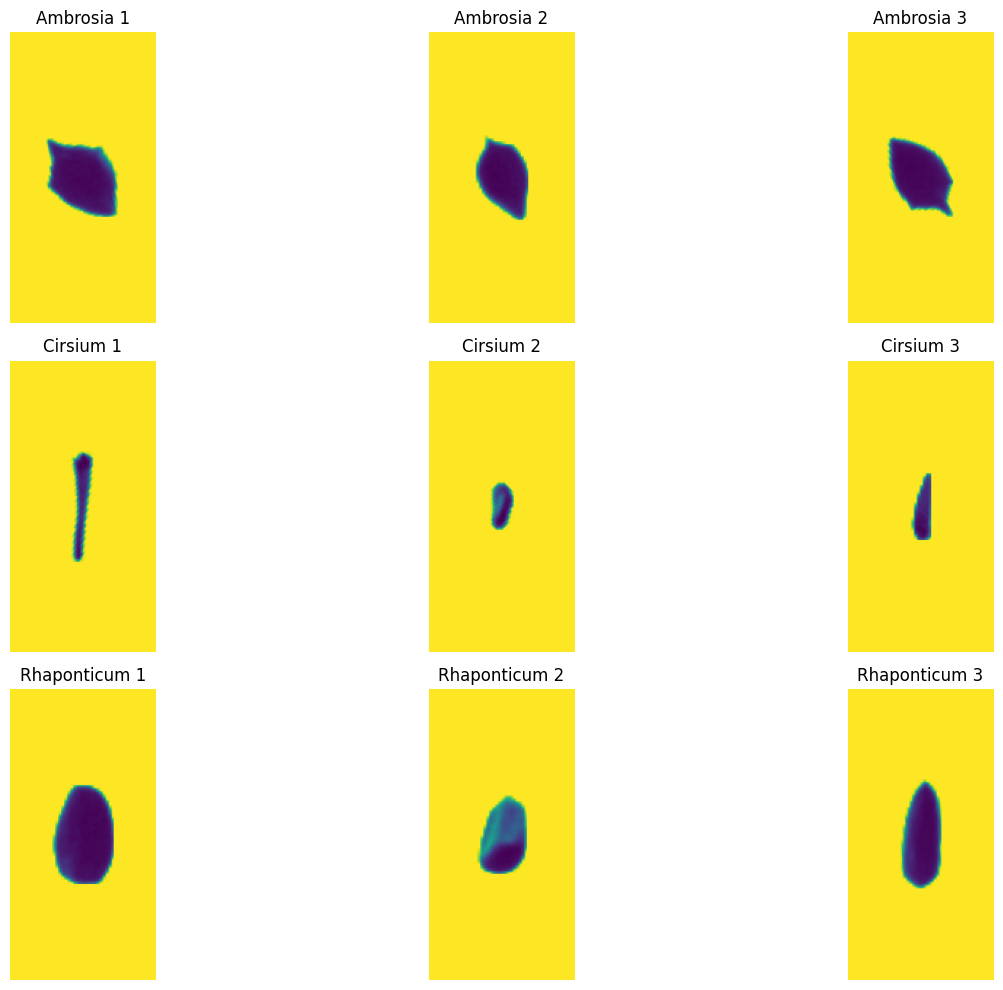

In [ ]:
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join('dataNIR', class_name)
    images = os.listdir(class_dir)

    # Select 3 random images from the current class
    selected_images = random.sample(images, 3)

    print(f"Displaying 3 images from class: {class_name}")

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(class_dir, img_name)
        img = plt.imread(img_path)

        # Create a subplot for each image
        # (Number of classes * 3 images per class, current image index)
        plt.subplot(len(class_names), 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.title(f"{class_name} {j+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def split_data(source_dir, dest_dir, class_names, split_ratios):
    """
    Splits image data from a source directory into train, validation, and test sets
    in a specified destination directory.

    Args:
        source_dir (str): Path to the directory containing class subdirectories with images.
        dest_dir (str): Base path for the destination directory where split data will be stored.
        class_names (list): A list of class names (e.g., ['Ambrosia', 'Cirsium']).
        split_ratios (tuple): A tuple of (train_ratio, val_ratio, test_ratio).
    """

    train_ratio, val_ratio, test_ratio = split_ratios

    # Create base directories for train, val, test splits
    for split_type in ['train', 'val', 'test']:
        os.makedirs(os.path.join(dest_dir, split_type), exist_ok=True)
        print(f"Created directory: {os.path.join(dest_dir, split_type)}")

    print("\nStarting data splitting...")

    for class_name in class_names:
        source_class_path = os.path.join(source_dir, class_name)
        if not os.path.exists(source_class_path):
            print(f"Warning: Class directory {source_class_path} not found. Skipping.")
            continue

        images = os.listdir(source_class_path)
        images = [img for img in images if os.path.isfile(os.path.join(source_class_path, img))]
        random.shuffle(images)

        total_images = len(images)
        train_size = int(total_images * train_ratio)
        val_size = int(total_images * val_ratio)
        # Test size takes the rest to ensure all images are used, accounting for potential rounding errors
        test_size = total_images - train_size - val_size

        train_images = images[:train_size]
        val_images = images[train_size : train_size + val_size]
        test_images = images[train_size + val_size :]

        print(f"\nProcessing class: {class_name} (Total images: {total_images})")
        print(f"  Train: {len(train_images)} images, Val: {len(val_images)} images, Test: {len(test_images)} images")

        # Copy images to their respective split directories
        for split_type, image_list in [('train', train_images), ('val', val_images), ('test', test_images)]:
            dest_class_path = os.path.join(dest_dir, split_type, class_name)
            os.makedirs(dest_class_path, exist_ok=True)
            for img_name in image_list:
                src_path = os.path.join(source_class_path, img_name)
                dst_path = os.path.join(dest_class_path, img_name)
                shutil.copyfile(src_path, dst_path)

    print("\nData splitting process complete.")


In [ ]:
source_dir = 'dataRGB'
dest_dir = 'dataRGB_split'
class_names = ['Ambrosia', 'Cirsium', 'Rhaponticum']
split_ratios = (0.7, 0.15, 0.15)

split_data(source_dir, dest_dir, class_names, split_ratios)


Created directory: dataRGB_split/train
Created directory: dataRGB_split/val
Created directory: dataRGB_split/test

Starting data splitting...

Processing class: Ambrosia (Total images: 39534)
  Train: 27673 images, Val: 5930 images, Test: 5931 images

Processing class: Cirsium (Total images: 41150)
  Train: 28804 images, Val: 6172 images, Test: 6174 images

Processing class: Rhaponticum (Total images: 44812)
  Train: 31368 images, Val: 6721 images, Test: 6723 images

Data splitting process complete.


In [ ]:
print("\n--- Verifying Data Split ---")

split_types = ['train', 'val', 'test']
total_counts_per_split = {split_type: 0 for split_type in split_types}

for split_type in split_types:
    print(f"\nChecking {split_type} directory:")
    split_path = os.path.join(dest_dir, split_type)

    if not os.path.exists(split_path):
        print(f"  {split_path} does not exist.")
        continue

    for class_name in class_names:
        class_path = os.path.join(split_path, class_name)
        if os.path.exists(class_path):
            num_images = len(os.listdir(class_path))
            print(f"  {class_name}: {num_images} images")
            total_counts_per_split[split_type] += num_images
        else:
            print(f"  {class_path} does not exist.")

for split_type, count in total_counts_per_split.items():
    print(f"\nTotal images in {split_type} split: {count}")


--- Verifying Data Split ---

Checking train directory:
  Ambrosia: 27673 images
  Cirsium: 28804 images
  Rhaponticum: 31368 images

Checking val directory:
  Ambrosia: 5930 images
  Cirsium: 6172 images
  Rhaponticum: 6721 images

Checking test directory:
  Ambrosia: 5931 images
  Cirsium: 6174 images
  Rhaponticum: 6723 images

Total images in train split: 87845

Total images in val split: 18823

Total images in test split: 18828


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
IMG_SIZE = 224 # Common image size for many pre-trained models

# Define common mean and standard deviation for normalization
# These are often used with pre-trained models on ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training transformations with data augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Validation and Test transformations (no data augmentation, only resize and normalize)
val_test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

print("Image transformations for train, validation, and test sets defined.")


Image transformations for train, validation, and test sets defined.


In [ ]:
train_dir = os.path.join(dest_dir, 'train')
val_dir = os.path.join(dest_dir, 'val')
test_dir = os.path.join(dest_dir, 'test')

# Create ImageFolder datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

print("ImageFolder datasets for train, val, and test created.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

ImageFolder datasets for train, val, and test created.
Number of training samples: 87845
Number of validation samples: 18823
Number of test samples: 18828


In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 2 # Set to 0 if encountering issues, otherwise 2 or 4 is common

# Create DataLoader instances
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"DataLoaders created with batch_size={BATCH_SIZE} and num_workers={NUM_WORKERS}.")
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

DataLoaders created with batch_size=32 and num_workers=2.
Number of batches in training loader: 2746
Number of batches in validation loader: 589
Number of batches in test loader: 589


In [ ]:
import torch.nn as nn
import torchvision.models as models

In [ ]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# 1. Load a pre-trained MobileNetV3-Small model
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

# 2. Get the number of input features for the last classification layer
# The classifier of MobileNetV3 is a Sequential module with a Linear layer at index 3
num_ftrs = model.classifier[3].in_features

# 3. Replace the last classification layer with a new one for our number of classes
# The number of classes is determined from the 'class_names' list
num_classes = len(class_names)
model.classifier[3] = nn.Linear(num_ftrs, num_classes)

print(f"MobileNetV3-Small model loaded with pre-trained weights.")
print(f"Original last layer input features: {num_ftrs}")
print(f"New last layer output features (number of classes): {num_classes}")
print("Model's final classification layer has been modified.")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 151MB/s]

MobileNetV3-Small model loaded with pre-trained weights.
Original last layer input features: 1024
New last layer output features (number of classes): 3
Model's final classification layer has been modified.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model moved to: {device}")

Model moved to: cuda:0


In [ ]:
import torch.optim as optim

# 1. Define the loss function
criterion = nn.CrossEntropyLoss()

# 2. Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function (criterion) defined: {criterion}")
print(f"Optimizer defined: {optimizer} with learning rate: {learning_rate}")

Loss function (criterion) defined: CrossEntropyLoss()
Optimizer defined: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
) with learning rate: 0.001


In [ ]:
import torch.optim as optim
from tqdm import tqdm # For progress bar

# Best practice for Colab to avoid deadlocks with num_workers > 0
torch.set_num_threads(1)

# 1. Define the number of training epochs
num_epochs = 10

# 2. Initialize empty lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0.0 # To keep track of the best validation accuracy for model saving (optional)

print("Starting model training...")

# 3. Implement a loop that iterates for the defined number of epochs
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # ================================= TRAINING PHASE =================================
    # 4. Set the model to training mode
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # 5. Iterate through the train_loader
    for inputs, labels in tqdm(train_loader, desc="Training"): # Use tqdm for progress bar
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # 6. Accumulate and calculate training metrics for the current epoch
    epoch_train_loss = running_train_loss / total_train
    epoch_train_accuracy = correct_train / total_train

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # =============================== VALIDATION PHASE ===============================
    # 7. Set the model to evaluation mode
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # 8. With torch.no_grad(), iterate through the val_loader
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"): # Use tqdm for progress bar
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # 9. Print and store validation metrics for the current epoch
    epoch_val_loss = running_val_loss / total_val
    epoch_val_accuracy = correct_val / total_val

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    # 10. Consider saving the model's state dictionary if validation accuracy improves
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  Saved best model with validation accuracy: {best_val_accuracy:.4f}")

print("\nTraining complete!")


Starting model training...

Epoch 1/10


Validation: 100%|██████████| 589/589 [00:52<00:00, 11.20it/s]


Train Loss: 0.2516, Train Acc: 0.8860 | Val Loss: 0.0200, Val Acc: 0.9929
  Saved best model with validation accuracy: 0.9929

Epoch 2/10


Validation: 100%|██████████| 589/589 [00:52<00:00, 11.32it/s]


Train Loss: 0.2014, Train Acc: 0.9060 | Val Loss: 0.0218, Val Acc: 0.9935
  Saved best model with validation accuracy: 0.9935

Epoch 3/10


Validation: 100%|██████████| 589/589 [00:51<00:00, 11.36it/s]


Train Loss: 0.1924, Train Acc: 0.9106 | Val Loss: 0.0213, Val Acc: 0.9928

Epoch 4/10


Validation: 100%|██████████| 589/589 [00:53<00:00, 10.95it/s]


Train Loss: 0.1829, Train Acc: 0.9123 | Val Loss: 0.0205, Val Acc: 0.9934

Epoch 5/10


Validation: 100%|██████████| 589/589 [00:51<00:00, 11.34it/s]


Train Loss: 0.1789, Train Acc: 0.9155 | Val Loss: 0.1495, Val Acc: 0.9328

Epoch 6/10


Validation: 100%|██████████| 589/589 [00:53<00:00, 11.11it/s]


Train Loss: 0.1767, Train Acc: 0.9149 | Val Loss: 0.3333, Val Acc: 0.8957

Epoch 7/10


Validation: 100%|██████████| 589/589 [00:51<00:00, 11.43it/s]


Train Loss: 0.1724, Train Acc: 0.9183 | Val Loss: 0.0523, Val Acc: 0.9849

Epoch 8/10


Validation: 100%|██████████| 589/589 [00:55<00:00, 10.70it/s]


Train Loss: 0.1708, Train Acc: 0.9186 | Val Loss: 0.0305, Val Acc: 0.9894

Epoch 9/10


Validation: 100%|██████████| 589/589 [00:53<00:00, 10.98it/s]


Train Loss: 0.1694, Train Acc: 0.9177 | Val Loss: 1.3141, Val Acc: 0.6698

Epoch 10/10


Validation: 100%|██████████| 589/589 [00:53<00:00, 10.97it/s]

Train Loss: 0.1690, Train Acc: 0.9195 | Val Loss: 5.1865, Val Acc: 0.3993

Training complete!


NameError: name 'num_epochs' is not defined

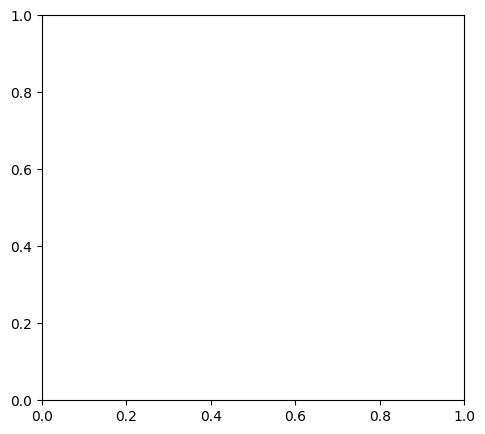

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
